# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
# CHANGE ME: Set this to the path to the Nuscene metadata ego_pose.json
NUSCENE_DATA_PATH = "~/nuscene-meta/v1.0-trainval"

In [2]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [3]:
import os
import json 

def read_json(path: str) -> list:
    with open(path, "r") as f:
        return json.load(f)


# load necessary files
ego_pose_json = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "ego_pose.json"))
sample_json  = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "sample.json"))
sample_data_json = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "sample_data.json"))

In [4]:
from collections import defaultdict

# build scene lookup dict
scene_token_by_sample_token: dict[str, str] = { sample["token"]: sample["scene_token"] for sample in sample_json }

# build ego_pose lookup dict
ego_pose_by_ego_pose_token: dict[str, dict] = { ego_pose["token"]: ego_pose for ego_pose in ego_pose_json }

# build list of ego_pose_tokens for each scene
ego_pose_token_by_scene_token: defaultdict[str, set[str]] = defaultdict(set)
for sample_data in sample_data_json:
    scene_token = scene_token_by_sample_token[sample_data["sample_token"]]
    ego_pose_token_by_scene_token[scene_token].add(sample_data["token"])


In [5]:
from scipy.spatial.transform import Rotation
from scipy.spatial.transform import Slerp
from scipy.ndimage import gaussian_filter1d

trajectories: list[list[State]] = []

for scene_token, ego_pose_tokens in ego_pose_token_by_scene_token.items():
    # sort ego poses by timestamp and deduplicate
    ego_poses = [ego_pose_by_ego_pose_token[ego_pose_token] for ego_pose_token in ego_pose_tokens]
    ego_poses = sorted(ego_poses, key=lambda x: x["timestamp"])
    ego_poses = [ego_poses[i] for i in range(len(ego_poses)) if i == 0 or ego_poses[i]["timestamp"] - ego_poses[i-1]["timestamp"] > 0.001*1e6]

    # gather data
    time_micros: list[int] = []
    quaternions: list[list[float]] = []
    xs: list[float] = []
    ys: list[float] = []
    zs: list[float] = []

    for ego_pose in ego_poses:
        time_micros.append(ego_pose["timestamp"])

        qw, qx, qy, qz = ego_pose["rotation"] 
        quaternions.append([qx, qy, qz, qw])

        x, y, z = ego_pose["translation"]
        xs.append(x)
        ys.append(y)
        zs.append(z)

    if len(time_micros) < 2:
        print(f"Skipping scene {scene_token} because it has no data")
        continue

    # convert time to seconds
    times = np.array(time_micros, dtype=np.float64) / 1e6

    # sample at 10Hz
    sample_times = np.arange(times[0], times[-1], 0.1)

    # get headings at sampled times
    rotation_interpolator = Slerp(times, Rotation.from_quat(quaternions))
    headings = rotation_interpolator(sample_times).as_euler('xyz')[:, 2]

    # get velocities at sampled times
    tdiff = np.diff(times)
    xvel_smoothed = gaussian_filter1d(np.diff(xs) / tdiff, sigma=32)
    yvel_smoothed = gaussian_filter1d(np.diff(ys) / tdiff, sigma=32)

    x_vel = np.interp(sample_times, times[:-1], xvel_smoothed)
    y_vel = np.interp(sample_times, times[:-1], yvel_smoothed)

    velocities = np.stack([x_vel, y_vel], axis=1)

    # create trajectory
    trajectory = [State(heading=h, velocity=v) for h, v in zip(headings, velocities)]
    trajectories.append(trajectory)

In [6]:
sum([len(t) for t in trajectories])

167146

In [7]:
import pickle
import os
import lzma

# pickle the trajectories
if not os.path.exists('nuscene_data/trajectories.pkl.xz'):
    with lzma.open('nuscene_data/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [8]:
import pickle
import lzma

# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('nuscene_data/trajectories.pkl.xz', 'rb') as f:
        trajectories = pickle.load(f)

In [9]:
import random

idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [10]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 149666
validation data: 16630


In [11]:
import matplotlib.pyplot as plt
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F



def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_random_action() -> Action:
    """
    Generates a random action with probabilities that are similar to that are found in the waymo dataset
    """
    a = tuple(np.random.normal(0, 0.5, 2))
    return a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 4)
    """
    velocities = torch.tensor(np.stack([st.velocity for st in states]), dtype=torch.float32, device=device)
    heading = torch.tensor([st.heading for st in states], dtype=torch.float32, device=device)
    return torch.cat([velocities, torch.cos(heading).unsqueeze(1), torch.sin(heading).unsqueeze(1)], dim=1)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 4, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [np.cos(st0.heading), np.cos(st1.heading)],
            [np.sin(st0.heading), np.sin(st1.heading)],
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [12]:
def generate_data(s0_batch: list[State]) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for s0 in s0_batch:
        a = gen_random_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [13]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_train_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_train_data.extend(batch)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/

In [14]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_validation_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_validation_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_validation_data.extend(batch)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/

In [15]:
import pickle
import os
import lzma

# pickle the data
if not os.path.exists('nuscene_data/mm_train_data.pkl.xz'):
    with lzma.open('nuscene_data/mm_train_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('nuscene_data/mm_validation_data.pkl.xz'):
    with lzma.open('nuscene_data/mm_validation_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [16]:
import pickle
import os
import lzma

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with lzma.open('nuscene_data/mm_train_data.pkl.xz', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with lzma.open('nuscene_data/mm_validation_data.pkl.xz', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [17]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 149666
validation data: 16630


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(6, 768)
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 4)
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        # clip actions to be between -1 and 1
        actions = torch.clamp(actions, -1, 1)
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = states + x
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [19]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [21]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 10000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch, a_batch, s1_batch = zip(*data_batch)
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 500, Loss: 0.0111
Step: 1000, Loss: 0.0030
Step: 1500, Loss: 0.0013
Step: 2000, Loss: 0.0008
Step: 2500, Loss: 0.0006
Step: 3000, Loss: 0.0005
Step: 3500, Loss: 0.0004
Step: 4000, Loss: 0.0004
Step: 4500, Loss: 0.0004
Step: 5000, Loss: 0.0003
Step: 5500, Loss: 0.0003
Step: 6000, Loss: 0.0003
Step: 6500, Loss: 0.0003
Step: 7000, Loss: 0.0003
Step: 7500, Loss: 0.0003
Step: 8000, Loss: 0.0003
Step: 8500, Loss: 0.0002
Step: 9000, Loss: 0.0003
Step: 9500, Loss: 0.0002
Step: 10000, Loss: 0.0002


In [22]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('nuscene_data/mm.pth'))

In [23]:
# save mm
if not os.path.exists('nuscene_data/mm.pth'):
    torch.save(mm.state_dict(), 'nuscene_data/mm.pth')

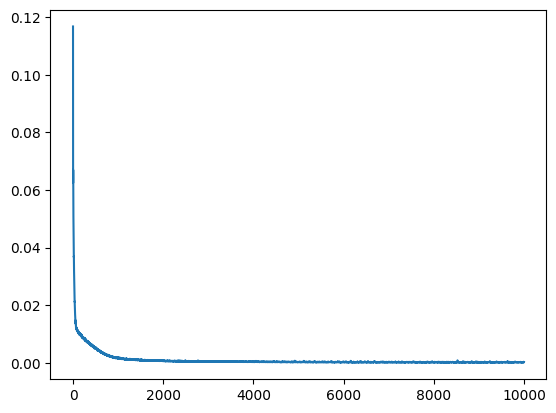

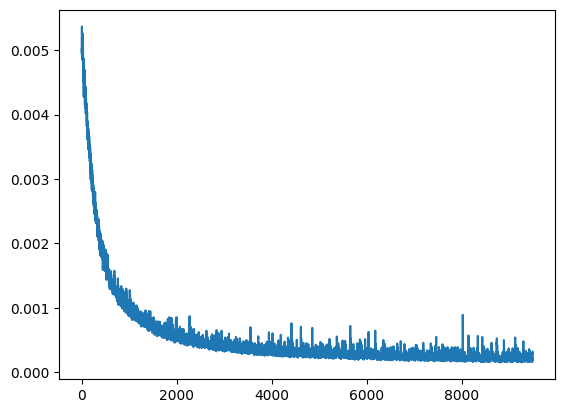

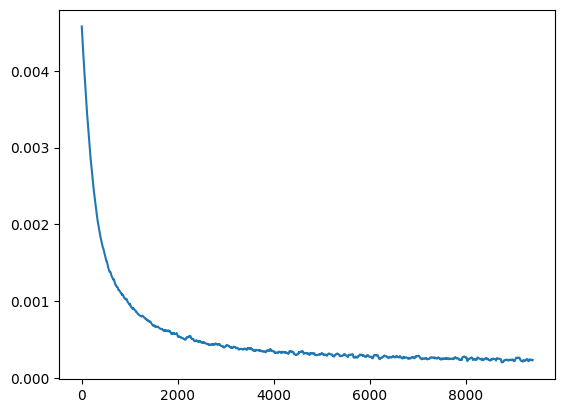

In [24]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# running average of last 100 losses
latter_training_averaged = np.convolve(latter_training, np.ones((100,))/100, mode='valid')
plt.plot(list(range(len(latter_training_averaged))), latter_training_averaged, label='MM')
plt.show()

In [25]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("training loss", loss.mean().item())

training loss 0.0002708838146645576


In [26]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("validation loss", loss.mean().item())

validation loss 0.0002739818883128464


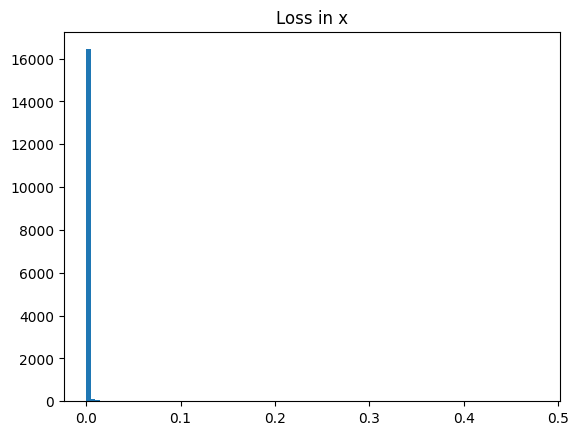

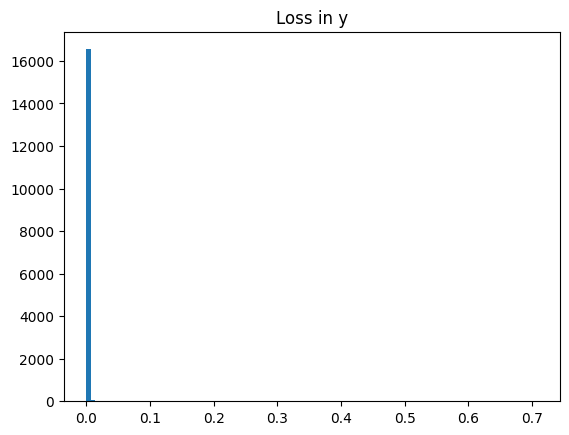

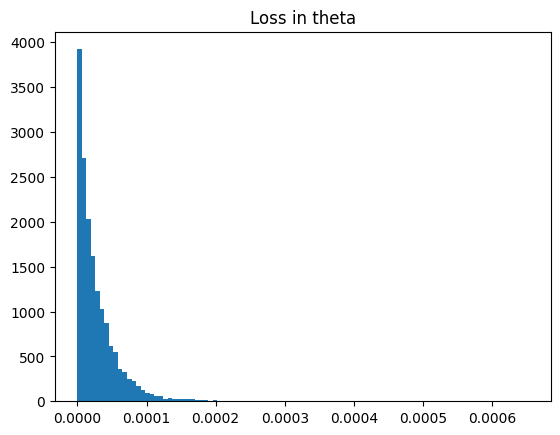

In [27]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [28]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [29]:
import itertools

idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [30]:
for ti, trajectory in enumerate(trajectories):
    for i in range(len(trajectory)-1):
        s0 = trajectory[i]
        s1 = trajectory[i+1]
        acc = (s1.velocity - s0.velocity) / 0.1
        if np.linalg.norm(acc) > 10:
            print("bad acceleration", ti, i, acc)

bad acceleration 461 10 [9.52609264 3.9988373 ]
bad acceleration 814 1 [-6.01543898 -8.93977778]
bad acceleration 814 2 [ -7.40249401 -10.97709809]


In [31]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 5500
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-100:])
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

Step: 100, Loss: 0.0088
Step: 200, Loss: 0.0017
Step: 300, Loss: 0.0016
Step: 400, Loss: 0.0016
Step: 500, Loss: 0.0014
Step: 600, Loss: 0.0014
Step: 700, Loss: 0.0012
Step: 800, Loss: 0.0012
Step: 900, Loss: 0.0010
Step: 1000, Loss: 0.0010
Step: 1100, Loss: 0.0008
Step: 1200, Loss: 0.0008
Step: 1300, Loss: 0.0008
Step: 1400, Loss: 0.0007
Step: 1500, Loss: 0.0007
Step: 1600, Loss: 0.0007
Step: 1700, Loss: 0.0006
Step: 1800, Loss: 0.0006
Step: 1900, Loss: 0.0005
Step: 2000, Loss: 0.0006
Step: 2100, Loss: 0.0005
Step: 2200, Loss: 0.0005
Step: 2300, Loss: 0.0005
Step: 2400, Loss: 0.0006
Step: 2500, Loss: 0.0004
Step: 2600, Loss: 0.0004
Step: 2700, Loss: 0.0005
Step: 2800, Loss: 0.0004
Step: 2900, Loss: 0.0004
Step: 3000, Loss: 0.0004
Step: 3100, Loss: 0.0004
Step: 3200, Loss: 0.0004
Step: 3300, Loss: 0.0004
Step: 3400, Loss: 0.0004
Step: 3500, Loss: 0.0004
Step: 3600, Loss: 0.0004
Step: 3700, Loss: 0.0004
Step: 3800, Loss: 0.0004
Step: 3900, Loss: 0.0003
Step: 4000, Loss: 0.0004
Step: 410

In [32]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('nuscene_data/idm.pth'))    

In [33]:
# save idm
if not os.path.exists('nuscene_data/idm.pth'):
    torch.save(idm.state_dict(), 'nuscene_data/idm.pth')

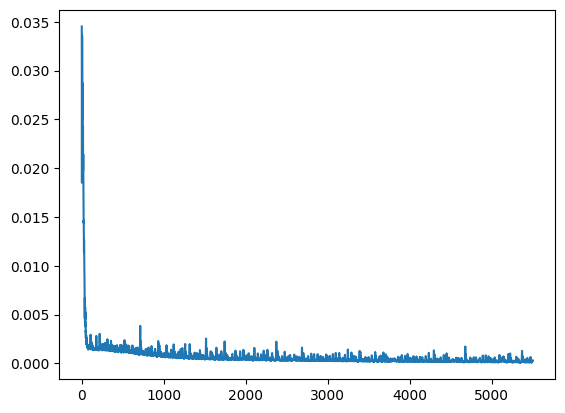

In [34]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

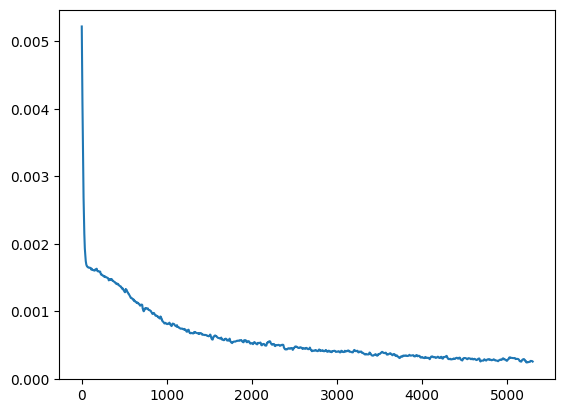

In [35]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [36]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.0002783819509204477


In [37]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.00026904602418653667


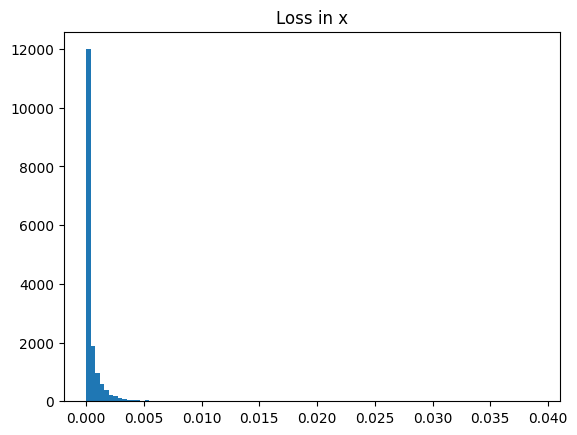

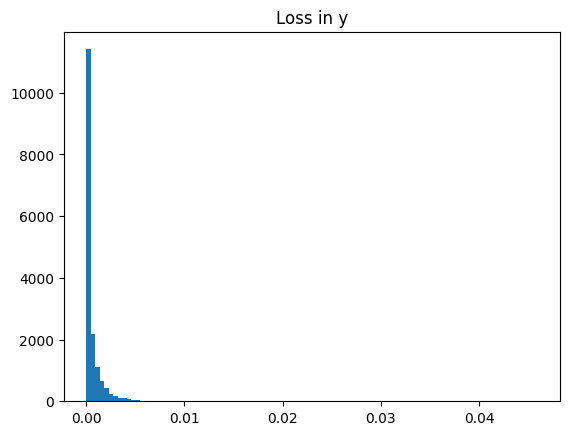

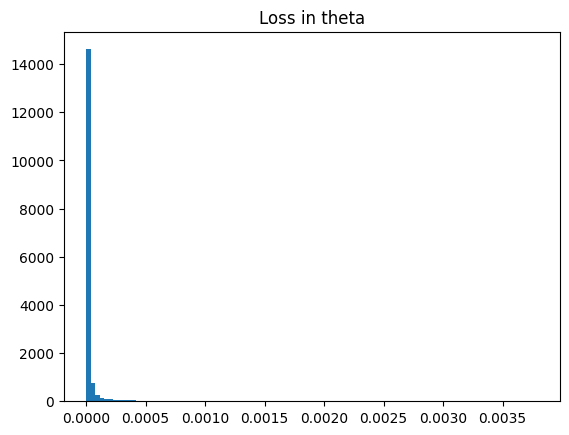

In [38]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


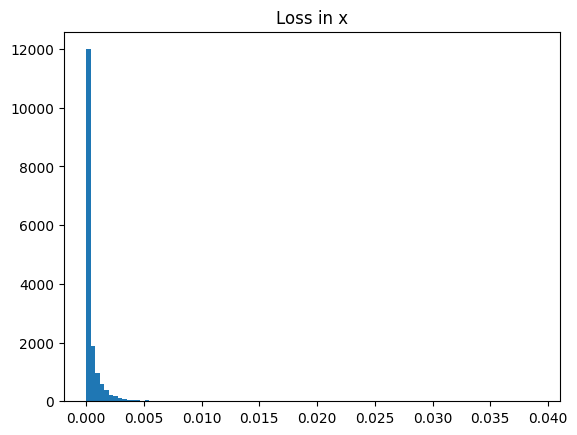

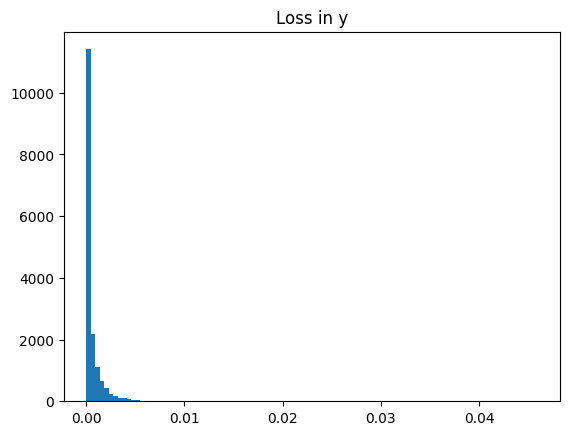

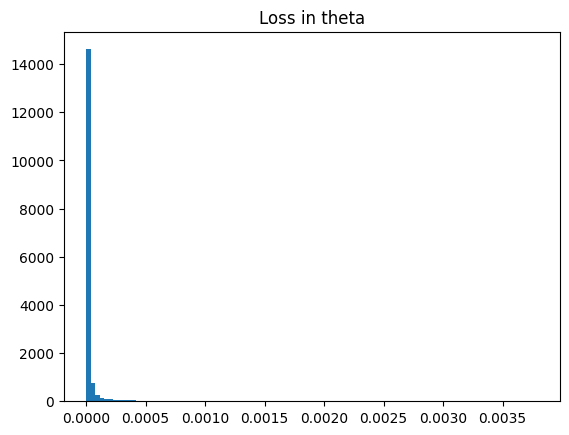

In [39]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [40]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [41]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

### Trajectory Replay

In [42]:
scenario = trajectories[7]

# reset
env.reset()

# allow car to settle
for _ in range(10):
    env.step([0,0])

# set the initial state
for i in range(len(scenario)):
    st = scenario[i]
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])        

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env

### Closed Loop IDM

In [43]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(0.004243871662765741, 0.103353351354599)
[-5.69162512  4.38240147] 2.4845671105335434 [-5.65642031  4.39342294] 2.483908400032743
(-0.005200808402150869, 0.07557400315999985)
[-5.69911909  4.40675259] 2.4847549965484483 [-5.66989076  4.40516409] 2.4844115248886087
(-0.0010028309188783169, 0.09520760178565979)
[-5.7216053   4.42065573] 2.4842521917346416 [-5.69083846  4.42492795] 2.4849777889078846
(-0.0022153700701892376, 0.05814439803361893)
[-5.73146534  4.43414879] 2.4839016531561597 [-5.69852731  4.43348925] 2.4845823547272423
(-0.0009955181740224361, 0.03203623741865158)
[-5.73838663  4.43966293] 2.483543990621762 [-5.70152702  4.43759271] 2.4839918310522684
(-0.000891850795596838, 0.01825830340385437)
[-5.74173832  4.44356823] 2.483305304809064 [-5.70393936  4.43929238] 2.4839769020829023
(-0.00026707863435149193, 0.016758335754275322)
[-5.7456255   4.44611025] 2.4831409211907784 [-5.70814334  4.44105814] 2.4838380702845986
(0.0003528189845383167, 0.03099842183291912)
[-5.753175

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007621073164045811, 0.03386601060628891)
[-5.77185059  4.46126413] 2.4832841326783974 [-5.73813692  4.45581795] 2.4860919100898027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012086299248039722, 0.04296167939901352)
[-5.78263855  4.46670628] 2.483455973147735 [-5.75018777  4.46181707] 2.4861371354052584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015193433500826359, 0.04164864122867584)
[-5.79334354  4.47165871] 2.4836965231731964 [-5.76118343  4.46603341] 2.486388121292089


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002562523353844881, 0.04219241067767143)
[-5.80564117  4.4747839 ] 2.4840388059522986 [-5.77434062  4.46796479] 2.486342703084164


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0032473918981850147, 0.03368788957595825)
[-5.81651926  4.4758997 ] 2.4845462712980133 [-5.78537221  4.46695503] 2.487328407627336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366524983197451, 0.027684712782502174)
[-5.82738781  4.47428894] 2.48522231474073 [-5.79684974  4.46295681] 2.48785020912479


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004962977487593889, 0.01820429600775242)
[-5.83633804  4.47086763] 2.486084979196834 [-5.80608012  4.45638964] 2.488676987508812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00602520490065217, 0.008384008891880512)
[-5.84440184  4.46411657] 2.487111760955114 [-5.81404254  4.44637504] 2.490121614920672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006407630164176226, -0.0013770193327218294)
[-5.8487215   4.45474339] 2.48830605554596 [-5.81931176  4.43489944] 2.49153893051717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004900716710835695, -0.0005996872205287218)
[-5.85126925  4.44979382] 2.489509338305485 [-5.82064182  4.43009678] 2.4920078657821416


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0035433252342045307, 0.0006055652629584074)
[-5.85347414  4.44718122] 2.490497770544068 [-5.82068729  4.42955335] 2.4932887605975314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0018297978676855564, 0.004453561268746853)
[-5.85480165  4.447474  ] 2.4912064377101384 [-5.82042328  4.43321441] 2.4937002294301633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005068429745733738, 0.00997891929000616)
[-5.85648632  4.44981241] 2.491603448449642 [-5.82075626  4.43909498] 2.493121976536027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008557583205401897, 0.020040055736899376)
[-5.85916042  4.45543432] 2.4917166993749973 [-5.82303137  4.44861275] 2.4926416930539883


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013567539863288403, 0.025695057585835457)
[-5.8632369   4.46179104] 2.491593128700418 [-5.82650816  4.45717457] 2.4920213047760553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002455900888890028, 0.03924842178821564)
[-5.86888027  4.47226524] 2.491299981243427 [-5.83258131  4.4704118 ] 2.4916377742737006


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036735120229423046, 0.055328089743852615)
[-5.87676907  4.48710489] 2.4907919166864674 [-5.8408676   4.48867817] 2.4907401954971777


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00415005860850215, 0.05778948962688446)
[-5.88526106  4.50226402] 2.490079521094871 [-5.84830577  4.50573568] 2.4898850142106292


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005429746117442846, 0.06848166137933731)
[-5.89432716  4.52150869] 2.4891981479321093 [-5.85743302  4.52763613] 2.488895479058234


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004860540386289358, 0.05736590549349785)
[-5.90279722  4.53648901] 2.488170167751339 [-5.86355584  4.54278918] 2.4880513057444835


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004642230924218893, 0.04731195420026779)
[-5.9090414   4.54979944] 2.487168819181469 [-5.86873099  4.55487216] 2.486786362158203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0041013299487531185, 0.041977278888225555)
[-5.91479969  4.5613203 ] 2.486224262521845 [-5.87419228  4.56555598] 2.4862072120098047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036361361853778362, 0.03997654840350151)
[-5.92046309  4.57204914] 2.4853719843939928 [-5.88014147  4.5756592 ] 2.4865666949278618


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003650698345154524, 0.04957570135593414)
[-5.92781115  4.58493042] 2.4845906129301634 [-5.88888989  4.58948594] 2.4862098804735764


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003778697457164526, 0.06584770977497101)
[-5.93845034  4.60089016] 2.483819494636531 [-5.90133676  4.60762965] 2.4854721766826002


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0037304512225091457, 0.08285535871982574)
[-5.95295763  4.61952019] 2.4830390552790833 [-5.91756186  4.62826555] 2.4852186189226027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030869650654494762, 0.08562137931585312)
[-5.96913195  4.63724566] 2.4822914393820708 [-5.93408566  4.64616139] 2.4841947016351393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002435592468827963, 0.0919940248131752)
[-5.98736668  4.65518475] 2.4816498172964434 [-5.95349351  4.66411806] 2.484302706090098


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015745102427899837, 0.0787997916340828)
[-6.00363159  4.66972256] 2.4811467461665275 [-5.96914449  4.67658743] 2.4846022585026457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010517979972064495, 0.04414302110671997)
[-6.01259375  4.67805576] 2.480796007850964 [-5.97491784  4.68070501] 2.4842485246340194


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010144910775125027, 0.01771126128733158)
[-6.01545954  4.6823411 ] 2.480542142020052 [-5.97478404  4.68117875] 2.4836664427318014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012621167115867138, 0.00343344802968204)
[-6.01472235  4.68482351] 2.480305054104008 [-5.9715896   4.68111136] 2.483381442147902


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016355491243302822, 0.0035706653725355864)
[-6.01355648  4.68793154] 2.480027419560367 [-5.96996717  4.68492299] 2.483264749577349


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002018421422690153, 0.022649940103292465)
[-6.01619196  4.69472027] 2.4796800101961662 [-5.97493957  4.69611921] 2.483293962567875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002293530385941267, 0.045858852565288544)
[-6.02369118  4.70569038] 2.4792597633761515 [-5.98499986  4.71045865] 2.483038286860925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0027992348186671734, 0.08555665612220764)
[-6.03914213  4.72428322] 2.47876434883437 [-6.00450836  4.73352496] 2.4816449016240556


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002289415802806616, 0.08201412856578827)
[-6.05505896  4.74069452] 2.4782218629203205 [-6.01981754  4.74983087] 2.4804563613114166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002354403492063284, 0.10437698662281036)
[-6.07537413  4.76150465] 2.477714397574606 [-6.04265254  4.7725246 ] 2.48050270626596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019531860016286373, 0.10333331674337387)
[-6.09615278  4.78125811] 2.477230368046484 [-6.06337562  4.79227667] 2.4808894611848857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014968994073569775, 0.05880098417401314)
[-6.10772276  4.79281759] 2.476817045445304 [-6.0706967   4.79947679] 2.480749175800382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012650336138904095, 0.03977825120091438)
[-6.1152339   4.80104256] 2.476482618991417 [-6.07633064  4.80526289] 2.4823924680757856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010078209452331066, 0.026437461376190186)
[-6.12010908  4.80665493] 2.476207581029839 [-6.07999641  4.80801144] 2.4818441556387705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003122384659945965, 0.0180463045835495)
[-6.12422037  4.80949259] 2.4760112394784732 [-6.08354244  4.80837055] 2.482373227336941


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011486080475151539, 0.01245440449565649)
[-6.1292634   4.80863857] 2.475986405501308 [-6.08921349  4.80460736] 2.4829848372592815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001894532237201929, 0.005156588740646839)
[-6.13286972  4.80634069] 2.4762001241787868 [-6.09337503  4.79883716] 2.4841375520633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0025560189969837666, 0.0006418086122721434)
[-6.13606977  4.80253458] 2.476593406492764 [-6.09669321  4.79269247] 2.485041738270852


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0028806705959141254, -0.0011284921783953905)
[-6.1378088   4.79732227] 2.477121111862764 [-6.0995322   4.78678763] 2.4850832265750014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002993952948600054, -0.0005729526747018099)
[-6.14022398  4.79271412] 2.47772471732383 [-6.10181235  4.78147119] 2.4851310654702528


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0033030849881470203, -0.0031780407298356295)
[-6.1397562   4.78490162] 2.4783763928425726 [-6.10335703  4.77435378] 2.485814961471922


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003250385168939829, -0.0029003743547946215)
[-6.13933945  4.7777586 ] 2.4790704126226473 [-6.10300015  4.76662436] 2.4856069644035665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0035635721869766712, -0.007242835126817226)
[-6.13391542  4.76553583] 2.479785870849497 [-6.10084638  4.75578962] 2.4864842661979014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003933888394385576, -0.006444805301725864)
[-6.12993956  4.75355196] 2.48055818756562 [-6.09707022  4.74267969] 2.487213098908655


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004312839824706316, -0.011278397403657436)
[-6.12011814  4.73626614] 2.4814038743697746 [-6.09124255  4.72646154] 2.488351367383771


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004981847945600748, -0.013858395628631115)
[-6.1078167   4.71530533] 2.482342838391109 [-6.08177206  4.70523409] 2.4887760189641837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004947195295244455, -0.010545625351369381)
[-6.09919357  4.69839191] 2.4833726162056156 [-6.07154924  4.68599466] 2.488759233789773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00452415132895112, -0.008420695550739765)
[-6.09251881  4.68460369] 2.4844001969122225 [-6.0633236   4.67149463] 2.490092718700193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037765507586300373, -0.001138174207881093)
[-6.09422827  4.67934561] 2.4853432222542198 [-6.0593266   4.66415922] 2.4907781264346123


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0030056298710405827, -0.00628125574439764)
[-6.08852005  4.6700058 ] 2.4861451000584425 [-6.05608281  4.65797294] 2.490885381595127


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0023440872319042683, -0.005688955076038837)
[-6.08302641  4.66196299] 2.4867931803097134 [-6.04919417  4.65090029] 2.4913023746550067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014024288393557072, -0.013873676769435406)
[-6.06584597  4.64728498] 2.487282136685852 [-6.03636692  4.64084745] 2.4908916600312243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000928324181586504, -0.019289664924144745)
[-6.0415163   4.62745142] 2.487605511021215 [-6.01483921  4.62449037] 2.4902846054625494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0004466869868338108, -0.02414255402982235)
[-6.01045895  4.60341692] 2.4878097754768236 [-5.98657109  4.60340501] 2.489411183860946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-8.082529529929161e-05, -0.029644500464200974)
[-5.97174263  4.57466078] 2.4879053829599576 [-5.95084453  4.57765218] 2.4880282740660613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010591051541268826, -0.04058536887168884)
[-5.91763544  4.53673124] 2.4878687644949693 [-5.89977576  4.54335827] 2.48738737537147


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001212043222039938, -0.022680139169096947)
[-5.8870945   4.51593018] 2.48769066559707 [-5.86045467  4.51900569] 2.4869766618982636


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00251574395224452, -0.03750026971101761)
[-5.83544064  4.48303509] 2.4873947218209347 [-5.81533693  4.49220371] 2.486631386569187


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002873459365218878, -0.035017821937799454)
[-5.78738403  4.45208406] 2.4869223436225822 [-5.76535431  4.4621371 ] 2.486172098875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003042032476514578, -0.03805334120988846)
[-5.73550749  4.41799831] 2.48636054979063 [-5.71426681  4.42924684] 2.4856408464425144


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025828550569713116, -0.047803811728954315)
[-5.67200327  4.37301636] 2.485785107258091 [-5.65505745  4.38667367] 2.4860725665422265


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014670523814857006, -0.03408878296613693)
[-5.62766838  4.33971024] 2.4853090006342122 [-5.60694725  4.34810245] 2.4870282728646336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004799230955541134, -0.04067130386829376)
[-5.57569075  4.29877996] 2.485016518967494 [-5.55950247  4.30703082] 2.487581728591337


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008262232877314091, -0.04600970447063446)
[-5.51808929  4.25091314] 2.484931897023857 [-5.5065401   4.25823354] 2.488674303566904


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002358251716941595, -0.04707339406013489)
[-5.46044636  4.20025826] 2.4850982114339324 [-5.45221363  4.20483574] 2.490093536685331


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043830773793160915, -0.053845733404159546)
[-5.39598465  4.14037609] 2.4855667280487044 [-5.39382269  4.14257651] 2.4911486100973947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00572955934330821, -0.028185924515128136)
[-5.36509323  4.1052866 ] 2.4863599505793847 [-5.35439313  4.09681345] 2.492245490462816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007599004078656435, -0.049372073262929916)
[-5.30844259  4.04711151] 2.4874445229333193 [-5.30939465  4.04035161] 2.4942598033350403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00946761853992939, -0.029109837487339973)
[-5.27921629  4.00727177] 2.488850605409854 [-5.27259328  3.99132118] 2.4967171850269407


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010311329737305641, -0.03885936737060547)
[-5.23699808  3.95828247] 2.4905408471747 [-5.23678652  3.94255677] 2.5003411030927594


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.013723662123084068, -0.05353967100381851)
[-5.17961359  3.88960433] 2.492519442706574 [-5.18495766  3.87218195] 2.5035452825124755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.014055820181965828, -0.03538518026471138)
[-5.14376783  3.84139347] 2.4948698155266236 [-5.14551909  3.81815945] 2.506961914838205


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.015855969861149788, -0.04172751307487488)
[-5.10128975  3.78469753] 2.497413733578895 [-5.10475653  3.75969302] 2.510422555598565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.019429154694080353, -0.04630318284034729)
[-5.05613804  3.71887803] 2.500294408351006 [-5.0601804   3.68951318] 2.514886077386571


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02248603291809559, -0.04332359507679939)
[-5.015944    3.65427041] 2.5036727613518264 [-5.02071031  3.61925205] 2.5205191464969214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03469295799732208, -0.06411039084196091)
[-4.96101856  3.55126381] 2.507918505919685 [-4.96596985  3.50867434] 2.527654630995774


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03491080179810524, -0.05198422819375992)
[-4.91389227  3.47130919] 2.5133597435008808 [-4.92415454  3.41952127] 2.535712586555741


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04077561944723129, -0.05011222884058952)
[-4.87395763  3.3856194 ] 2.519332348298574 [-4.8825844   3.33077736] 2.544305139518269


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04471845179796219, -0.054245997220277786)
[-4.82849026  3.29545879] 2.526008427098212 [-4.83976722  3.23651914] 2.5532626869190698


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.052339013665914536, -0.055973805487155914)
[-4.78534842  3.19559622] 2.5334118151915503 [-4.79605959  3.12926299] 2.563240645522112


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06833014637231827, -0.06545707583427429)
[-4.73999166  3.06824565] 2.5421274093329984 [-4.74786623  2.98298108] 2.574824917953801


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06513617187738419, -0.048610251396894455)
[-4.70362234  2.97791743] 2.552182906397892 [-4.71935657  2.88290352] 2.5868741692454824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07208792865276337, -0.04445352405309677)
[-4.67803574  2.88105965] 2.562530818550477 [-4.6882469   2.78060705] 2.6001760555259668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0752992182970047, -0.05306011810898781)
[-4.63857889  2.77866673] 2.573478874054711 [-4.647974    2.67280781] 2.6153674698116975


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08072828501462936, -0.0647052675485611)
[-4.58375359  2.66304946] 2.584886724321147 [-4.59257927  2.55399486] 2.631845548274459


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10059632360935211, -0.09547676146030426)
[-4.49643469  2.49795508] 2.5973180273945005 [-4.49752882  2.37817504] 2.6488045468680825


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09178002923727036, -0.0720655769109726)
[-4.42300987  2.38798666] 2.610842890990468 [-4.43494279  2.26638288] 2.6672879518644157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0941479280591011, -0.05576290562748909)
[-4.37376738  2.28652978] 2.6239525011934646 [-4.37949336  2.16762475] 2.6865799446292176


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10003001242876053, -0.06608381867408752)
[-4.31101656  2.17169571] 2.6371185704115714 [-4.31440762  2.0533795 ] 2.7052672301140506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10950466990470886, -0.07846496999263763)
[-4.2316699   2.04130816] 2.6507630099404835 [-4.23264946  1.91523897] 2.7254306015916243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12468484044075012, -0.09677721560001373)
[-4.12711573  1.88918877] 2.665322378461892 [-4.12990215  1.75145794] 2.7453498681844826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12787951529026031, -0.09051059931516647)
[-4.02396917  1.75697684] 2.680796809133852 [-4.03558416  1.60781065] 2.7650361298145856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13394124805927277, -0.07456022500991821)
[-3.9420681   1.63730299] 2.696542083288673 [-3.94979033  1.47829157] 2.7850857133068136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1294013261795044, -0.055282481014728546)
[-3.88194656  1.54630888] 2.7122901537626385 [-3.88743069  1.38183504] 2.8058349423749607


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1546405553817749, -0.06934576481580734)
[-3.80945945  1.41272998] 2.728234099734779 [-3.79855031  1.23548925] 2.8274707653537785


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15725955367088318, -0.06281337887048721)
[-3.73885059  1.30387795] 2.745354896592626 [-3.72565762  1.10490125] 2.85001308005285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16040833294391632, -0.04518355429172516)
[-3.69204736  1.21026063] 2.762734552708429 [-3.6685439   1.00095725] 2.87300796995926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16705234348773956, -0.04486452043056488)
[-3.64454103  1.11483979] 2.7802885127175774 [-3.60467573  0.89438185] 2.8967472576533466


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16190217435359955, -0.04427659511566162)
[-3.59296489  1.03541958] 2.7978591174835383 [-3.54853498  0.81233096] 2.920680791393702


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16618070006370544, -0.04508233815431595)
[-3.53985357  0.95037514] 2.8150385038853667 [-3.48136891  0.72411063] 2.94452847617458


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1852065920829773, -0.06408567726612091)
[-3.45811152  0.83989382] 2.832506310633251 [-3.37730834  0.59341035] 2.968086130197986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.18565240502357483, -0.05314789339900017)
[-3.38880873  0.75279552] 2.850617936574662 [-3.30600254  0.49563879] 2.993557269985077


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.19647879898548126, -0.03739467263221741)
[-3.3433547   0.66583985] 2.868894412187549 [-3.24887804  0.39980839] 3.019539240450464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.19772739708423615, -0.02854818105697632)
[-3.30930305  0.5915646 ] 2.887529748757324 [-3.21289929  0.31936137] 3.044229646442792


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.19825628399848938, -0.0161642637103796)
[-3.2933197   0.52469128] 2.906170544807334 [-3.18971713  0.24957475] 3.0700750950901647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.21574766933918, -0.0035565991420298815)
[-3.29699826  0.44204471] 2.9251358470361692 [-3.16289857  0.14750608] 3.096247809219605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.20698876678943634, -0.02434801496565342)
[-3.26496792  0.37841633] 2.9447124778932325 [-3.14564715  0.08360329] 3.1216376988517394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2198941707611084, 0.0015631977003067732)
[-3.27136922  0.30225456] 2.9642174697169734 [-3.11988100e+00 -2.76142977e-03] -3.1366379182463007


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2180100679397583, -0.016518929973244667)
[-3.24927592  0.2342362 ] 2.984202629485255 [-3.1017933  -0.07442536] -3.112510917142889


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.21514326333999634, -0.00014025461860001087)
[-3.25247264  0.17292404] 3.00408352649686 [-3.09499081 -0.13225232] -3.0878529499082434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24979305267333984, 0.0733288824558258)
[-3.2712872   0.07014553] 3.024590133206579 [-3.11505462 -0.26571096] -3.062676028877136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2465873658657074, 0.10290543735027313)
[-3.29870987 -0.00720387] 3.046819405667416 [-3.14980103 -0.35946889] -3.038164444781771


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2563595473766327, 0.1484079211950302)
[-3.3356607  -0.09458797] 3.069765068461484 [-3.18911673 -0.46282171] -3.013449352943371


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2520989179611206, 0.14148178696632385)
[-3.37052178 -0.17174892] 3.0934344452817815 [-3.20594115 -0.54492141] -2.987753622376352


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25064805150032043, 0.10551281273365021)
[-3.39360166 -0.25139883] 3.117260016500012 [-3.194248   -0.61843765] -2.9617551848534722


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2527720034122467, 0.03384966030716896)
[-3.394238  -0.3351849] 3.141215816295547 [-3.13899109 -0.69956754] -2.936590960775758


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2472706139087677, -0.021716823801398277)
[-3.35049295 -0.40653181] -3.1180286047906085 [-3.08818185 -0.76251791] -2.9120810501764063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2434433251619339, -0.016799842938780785)
[-3.31350088 -0.47541928] -3.094612627748032 [-3.05394732 -0.82195025] -2.887395424567185


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24069586396217346, -0.007071551866829395)
[-3.29056501 -0.54529607] -3.071683609710777 [-3.03140696 -0.88259446] -2.861462600829611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24981911480426788, 0.010978161357343197)
[-3.27635431 -0.62999034] -3.0488346196642784 [-3.01211247 -0.96752832] -2.8362860986967973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26091688871383667, 0.035548120737075806)
[-3.26424026 -0.72259116] -3.025328361460749 [-2.99927069 -1.07235986] -2.8102053531817326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25291240215301514, 0.03961758688092232)
[-3.25747132 -0.79717892] -3.0012817478720417 [-2.99656972 -1.14854162] -2.78350720206444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2601882815361023, 0.09248236566781998)
[-3.25824118 -0.88764024] -2.9772143616268325 [-3.00298786 -1.24895844] -2.7556877402172986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.264752596616745, 0.15160343050956726)
[-3.27142    -0.98493242] -2.952568669950912 [-3.02361113 -1.36139817] -2.7285078323185834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2663459777832031, 0.20598559081554413)
[-3.29650831 -1.08722472] -2.9272760964462115 [-3.05598183 -1.47701168] -2.7002929653573493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2738191783428192, 0.2798629105091095)
[-3.33371925 -1.20615101] -2.9012313130916185 [-3.10190977 -1.61584949] -2.6716372589048376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27667826414108276, 0.31723257899284363)
[-3.37674427 -1.33146727] -2.874135246896716 [-3.14484825 -1.75354424] -2.642554688228268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2706676721572876, 0.284286230802536)
[-3.4118731 -1.448578 ] -2.846300286657371 [-3.16781988 -1.86069868] -2.61315133349067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26990053057670593, 0.24496226012706757)
[-3.43058538 -1.56875992] -2.818180900813606 [-3.17135139 -1.96697749] -2.5838617688602037


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27383631467819214, 0.1857217699289322)
[-3.4258635  -1.69141805] -2.789600521785148 [-3.14231393 -2.07232795] -2.5559134154930088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2814260423183441, 0.11885567009449005)
[-3.39536452 -1.81435704] -2.7602611418460175 [-3.07583978 -2.17501134] -2.527185479714335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27540144324302673, 0.07182852923870087)
[-3.35815573 -1.91934443] -2.730326145929091 [-3.0147878  -2.25490289] -2.4986483689069923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27666765451431274, 0.06340274214744568)
[-3.3121779 -2.0269835] -2.700403001079015 [-2.9548537  -2.35005653] -2.4698516689043957


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.268598735332489, 0.06371664255857468)
[-3.27009559 -2.12502027] -2.6705397773534663 [-2.91280768 -2.43436899] -2.4401800773689484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27407023310661316, 0.0851951539516449)
[-3.21969461 -2.23714375] -2.64087296175831 [-2.86155091 -2.54229565] -2.4119042177742025


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2809513509273529, 0.10714410990476608)
[-3.16539884 -2.35691357] -2.610674312893466 [-2.79093182 -2.66785094] -2.383967820112345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26167502999305725, 0.08210215717554092)
[-3.12500739 -2.4479692 ] -2.5803301222750488 [-2.74619287 -2.73627516] -2.356817112894202


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26489022374153137, 0.0896245539188385)
[-3.06944633 -2.55298162] -2.5507669036462968 [-2.68131142 -2.83072831] -2.3291784839484735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2538743317127228, 0.08657646179199219)
[-3.02078938 -2.64624214] -2.5214376437193087 [-2.62394354 -2.91432296] -2.3012346279180873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2485203593969345, 0.0904017835855484)
[-2.9680624  -2.74101686] -2.492783228812547 [-2.56607485 -2.99833501] -2.2739528948805114


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2619662880897522, 0.12178599834442139)
[-2.89782    -2.85739017] -2.464118294419479 [-2.47655589 -3.12089878] -2.2449383978722866


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2502480149269104, 0.12126603722572327)
[-2.8443327  -2.95623136] -2.434877584598736 [-2.41204397 -3.20332973] -2.216904452360156


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2484334260225296, 0.12293094396591187)
[-2.78362608 -3.05751801] -2.4059985320540256 [-2.3474179  -3.28496769] -2.18892921342394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24721577763557434, 0.131561741232872)
[-2.71912551 -3.16073084] -2.3772012385547807 [-2.27769581 -3.37838041] -2.1601350567515043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24382007122039795, 0.1412469446659088)
[-2.65477347 -3.26343369] -2.348414331383787 [-2.21318809 -3.47755199] -2.1309354710631494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25854364037513733, 0.20967763662338257)
[-2.57502389 -3.39359236] -2.3191981226450733 [-2.13329092 -3.62736437] -2.1020736437199212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24295078217983246, 0.2125866860151291)
[-2.52043653 -3.50631213] -2.2891920203270413 [-2.08421679 -3.72679585] -2.073042182346496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24310137331485748, 0.24275536835193634)
[-2.45533514 -3.63099742] -2.2595598258260567 [-2.0228647  -3.83585532] -2.0447557052032126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23839998245239258, 0.2510271966457367)
[-2.38947201 -3.75517821] -2.2298589217689475 [-1.95124486 -3.93442357] -2.0163362620481426


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23513980209827423, 0.24474197626113892)
[-2.31618524 -3.87770581] -2.200192106173793 [-1.87266981 -4.02023057] -1.9887626952567496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24763350188732147, 0.2742185592651367)
[-2.21742773 -4.01621437] -2.170036600518607 [-1.75761393 -4.12949673] -1.9610024833063329


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2457733452320099, 0.2627735137939453)
[-2.12133551 -4.14603615] -2.138690928172265 [-1.65144778 -4.23015209] -1.9338364283979086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23796965181827545, 0.23888447880744934)
[-2.02782321 -4.26406384] -2.1070355301911476 [-1.56486767 -4.31903024] -1.907795564538717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23379945755004883, 0.2360340803861618)
[-1.92718506 -4.37987041] -2.075620083024246 [-1.47677595 -4.41929499] -1.8817535433043133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24211347103118896, 0.2883087396621704)
[-1.80537069 -4.51264668] -2.0439614892498206 [-1.36764469 -4.56318368] -1.8539792219285833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24031375348567963, 0.3316807150840759)
[-1.68796706 -4.65197849] -2.0113747838355014 [-1.26931039 -4.72158521] -1.824064351880716


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23374272882938385, 0.3668408691883087)
[-1.57544863 -4.79581499] -1.9784240243001694 [-1.18618553 -4.88473721] -1.7949889081411572


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22290821373462677, 0.41622936725616455)
[-1.47036505 -4.94797945] -1.9457102861018534 [-1.10194461 -5.06392753] -1.7664480691511708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.19939593970775604, 0.37463825941085815)
[-1.3836441  -5.08163738] -1.914135581901765 [-1.03839643 -5.18164197] -1.7386438704955516


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.20315350592136383, 0.403494268655777)
[-1.25706351 -5.22650623] -1.88396915728611 [-0.93099244 -5.32498008] -1.710736682546476


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22350196540355682, 0.444757342338562)
[-1.08065605 -5.38352489] -1.8527457240338032 [-0.7435165  -5.47808843] -1.6837717972476844


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.20305116474628448, 0.3580401837825775)
[-0.94892776 -5.50820971] -1.8200088163340045 [-0.60595623 -5.56421241] -1.6587913967911003


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.20997358858585358, 0.35955268144607544)
[-0.77750987 -5.63123465] -1.7876990796730539 [-0.4531937  -5.66685694] -1.6361473800258863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.17920096218585968, 0.30659034848213196)
[-0.66379774 -5.73296785] -1.755809057199901 [-0.35280124 -5.75184911] -1.6160628311376726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1705578863620758, 0.3265957534313202)
[-0.53013813 -5.83732748] -1.7264040303399 [-0.25407437 -5.85899962] -1.6000222438015719


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15692444145679474, 0.4055476486682892)
[-0.40566126 -5.95973825] -1.6986003622433632 [-0.14447532 -6.01524622] -1.5853365446360248


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12405551970005035, 0.33893221616744995)
[-0.32761151 -6.06078863] -1.67330033188761 [-0.09651874 -6.0993358 ] -1.5748638473855545


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11244915425777435, 0.3550061285495758)
[-0.23432869 -6.16404247] -1.651581454249687 [-0.03908236 -6.21632733] -1.5672686373941367


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08731582760810852, 0.3065810799598694)
[-0.17488453 -6.25225067] -1.6326541020663852 [-3.64548539e-04 -6.30701831e+00] -1.5610345003255117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07929261773824692, 0.3669816255569458)
[-0.1015113  -6.35565901] -1.6167555629908303 [ 0.04740921 -6.43401282] -1.5552289176436378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06393042206764221, 0.4077969491481781)
[-0.04837098 -6.46956587] -1.602871971596029 [ 0.08998452 -6.56283283] -1.5499954310486934


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05358787626028061, 0.3701472580432892)
[ 9.04230634e-04 -6.57238436e+00] -1.5911564596446617 [ 0.11773639 -6.65595546] -1.5457802654507298


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04424906522035599, 0.34690335392951965)
[ 0.04302616 -6.66835642] -1.5812502993378938 [ 0.14258547 -6.74621035] -1.5430056310790858


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03374128043651581, 0.27044281363487244)
[ 0.07281869 -6.74308681] -1.5730594810892455 [ 0.15660392 -6.80008051] -1.539378433145301


### Open Loop IDM

In [44]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(0.004243871662765741, 0.103353351354599)
[-5.69162512  4.38240194] 2.4845671105335434 [-5.65642031  4.39342294] 2.483908400032743
(0.004059039521962404, 0.12924547493457794)
[-5.72589445  4.39637518] 2.4852060028790532 [-5.66989076  4.40516409] 2.4844115248886087
(0.0035343472845852375, 0.15617945790290833)
[-5.76284885  4.41906977] 2.4859466279782043 [-5.69083846  4.42492795] 2.4849777889078846
(0.0038900026120245457, 0.11363726854324341)
[-5.79097986  4.43395042] 2.4866865872870827 [-5.69852731  4.43348925] 2.4845823547272423
(0.004176984075456858, 0.09784340113401413)
[-5.81627464  4.44535303] 2.4874764808664005 [-5.70152702  4.43759271] 2.4839918310522684
(0.004685622174292803, 0.09308323264122009)
[-5.84131908  4.4549036 ] 2.4883349508437873 [-5.70393936  4.43929238] 2.4839769020829023
(0.004972601775079966, 0.09680153429508209)
[-5.86734915  4.46484137] 2.489279108029248 [-5.70814334  4.44105814] 2.4838380702845986
(0.005338564980775118, 0.1127043291926384)
[-5.89726353  4.47690

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005425137002021074, 0.1209520772099495)
[-5.92892218  4.49043274] 2.4913775458101757 [-5.73104524  4.45213888] 2.485281671469755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005059259478002787, 0.10554086416959763)
[-5.95655346  4.50221395] 2.492469375278081 [-5.73813692  4.45581795] 2.4860919100898027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005322337616235018, 0.11918497085571289)
[-5.98795462  4.51523924] 2.493543761040846 [-5.75018777  4.46181707] 2.4861371354052584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005587798077613115, 0.11450617015361786)
[-6.01867294  4.5270052 ] 2.494655830533036 [-5.76118343  4.46603341] 2.486388121292089


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006438309792429209, 0.11566254496574402)
[-6.05090809  4.53725672] 2.495852455389836 [-5.77434062  4.46796479] 2.486342703084164


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006749123800545931, 0.1069263368844986)
[-6.08122492  4.54601479] 2.4971783101385316 [-5.78537221  4.46695503] 2.487328407627336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007404955569654703, 0.10362978279590607)
[-6.11169767  4.55300617] 2.4986092265922313 [-5.79684974  4.46295681] 2.48785020912479


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007548887748271227, 0.09529107809066772)
[-6.1401577   4.55881453] 2.5001470023846704 [-5.80608012  4.45638964] 2.488676987508812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008029909804463387, 0.08760741353034973)
[-6.16765261  4.562325  ] 2.501757016421678 [-5.81404254  4.44637504] 2.490121614920672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0077870977111160755, 0.08006298542022705)
[-6.19280195  4.56547546] 2.503426951583212 [-5.81931176  4.43489944] 2.49153893051717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005561223719269037, 0.0819716602563858)
[-6.21483278  4.57375383] 2.5049761789683385 [-5.82064182  4.43009678] 2.4920078657821416


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00441857660189271, 0.08540621399879456)
[-6.23721743  4.5831337 ] 2.5062045620211375 [-5.82068729  4.42955335] 2.4932887605975314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003392424900084734, 0.09117896109819412)
[-6.26012611  4.59448576] 2.507173087130572 [-5.82042328  4.43321441] 2.4937002294301633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0029770289547741413, 0.0958506166934967)
[-6.28420067  4.60641956] 2.507944405161286 [-5.82075626  4.43909498] 2.493121976536027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0025404528714716434, 0.10501448810100555)
[-6.30989981  4.62041473] 2.5085979448927915 [-5.82303137  4.44861275] 2.4926416930539883


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0030166995711624622, 0.10613837093114853)
[-6.33696222  4.63306427] 2.509200951142613 [-5.82650816  4.45717457] 2.4920213047760553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0024758917279541492, 0.11812664568424225)
[-6.36547089  4.64934587] 2.5098138110884674 [-5.83258131  4.4704118 ] 2.4916377742737006


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0018156026490032673, 0.1296527236700058)
[-6.39574337  4.66860676] 2.5103396522457033 [-5.8408676   4.48867817] 2.4907401954971777


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0021011107601225376, 0.1261373907327652)
[-6.4262228   4.68593359] 2.510787729099109 [-5.84830577  4.50573568] 2.4898850142106292


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014621713198721409, 0.13616181910037994)
[-6.45770216  4.70658875] 2.511211571186595 [-5.85743302  4.52763613] 2.488895479058234


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0026402813382446766, 0.12060315907001495)
[-6.48822165  4.72125149] 2.5116261587892934 [-5.86355584  4.54278918] 2.4880513057444835


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0032565691508352757, 0.11424948275089264)
[-6.51764536  4.73442745] 2.5121994707929605 [-5.86873099  4.55487216] 2.486786362158203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037325439043343067, 0.11252090334892273)
[-6.54706812  4.74678421] 2.512911733226502 [-5.87419228  4.56555598] 2.4862072120098047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00404352368786931, 0.11235595494508743)
[-6.57667828  4.75878954] 2.513733185264737 [-5.88014147  4.5756592 ] 2.4865666949278618


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037561156786978245, 0.12313447892665863)
[-6.60800457  4.77349806] 2.5146043052573015 [-5.88888989  4.58948594] 2.4862098804735764


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0035400264896452427, 0.1363869607448578)
[-6.64216423  4.79052877] 2.515447794953557 [-5.90133676  4.60762965] 2.4854721766826002


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037790187634527683, 0.14702899754047394)
[-6.6793704  4.8083415] 2.516275638578408 [-5.91756186  4.62826555] 2.4852186189226027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004528383258730173, 0.1436435729265213)
[-6.71710348  4.82380199] 2.5171697949144023 [-5.93408566  4.64616139] 2.4841947016351393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005163245368748903, 0.14901375770568848)
[-6.75670481  4.83917618] 2.5182044329978983 [-5.95349351  4.66411806] 2.484302706090098


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005784191656857729, 0.13362103700637817)
[-6.79352713  4.85110474] 2.519387542312166 [-5.96914449  4.67658743] 2.4846022585026457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0059270416386425495, 0.10227727144956589)
[-6.82321739  4.85810375] 2.5206922249301957 [-5.97491784  4.68070501] 2.4842485246340194


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005735934246331453, 0.08542665839195251)
[-6.84872198  4.86293602] 2.522038253124149 [-5.97478404  4.68117875] 2.4836664427318014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005367417354136705, 0.07854576408863068)
[-6.87219048  4.86733627] 2.5233550531251385 [-5.9715896   4.68111136] 2.483381442147902


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004816178698092699, 0.08712834864854813)
[-6.89688921  4.87408257] 2.52459282382078 [-5.96996717  4.68492299] 2.483264749577349


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366610664874315, 0.11059719324111938)
[-6.92653894  4.88504267] 2.525723402282546 [-5.97493957  4.69611921] 2.483293962567875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00456641661003232, 0.12512454390525818)
[-6.96018553  4.89727211] 2.5267877346121965 [-5.98499986  4.71045865] 2.483038286860925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043213558383286, 0.15626373887062073)
[-7.00035095  4.91516972] 2.5278462079874484 [-6.00450836  4.73352496] 2.4816449016240556


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0051790871657431126, 0.138187438249588)
[-7.03822899  4.92760086] 2.528928649812511 [-6.01981754  4.74983087] 2.4804563613114166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00523424381390214, 0.16175082325935364)
[-7.08099651  4.94437551] 2.5301234104565475 [-6.04265254  4.7725246 ] 2.48050270626596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00559265585616231, 0.15322579443454742)
[-7.12251663  4.95879698] 2.531381620913556 [-6.06337562  4.79227667] 2.4808894611848857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006001100409775972, 0.10879050195217133)
[-7.15455151  4.96532965] 2.5327264506850184 [-6.0706967   4.79947679] 2.480749175800382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006095190066844225, 0.10307791084051132)
[-7.18527126  4.97096062] 2.53415150818432 [-6.07633064  4.80526289] 2.4823924680757856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006271325517445803, 0.0952683836221695)
[-7.2145319   4.97487259] 2.535622838107561 [-6.07999641  4.80801144] 2.4818441556387705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006773064378648996, 0.09164214134216309)
[-7.24386311  4.97686863] 2.537160281004864 [-6.08354244  4.80837055] 2.482373227336941


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007947895675897598, 0.09029966592788696)
[-7.27478123  4.97582006] 2.5388481925037563 [-6.08921349  4.80460736] 2.4829848372592815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008100096136331558, 0.084620401263237)
[-7.3039155   4.97455311] 2.5407283842333523 [-6.09337503  4.79883716] 2.4841375520633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008007222786545753, 0.08259476721286774)
[-7.33235025  4.97326899] 2.54267781815129 [-6.09669321  4.79269247] 2.485041738270852


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007832692936062813, 0.08212046325206757)
[-7.3605032   4.97211504] 2.544627185490201 [-6.0995322   4.78678763] 2.4850832265750014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007626707199960947, 0.08180218935012817)
[-7.38839054  4.97114468] 2.546546192792685 [-6.10181235  4.78147119] 2.4851310654702528


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007852688431739807, 0.07787872850894928)
[-7.4159956  4.9685812] 2.5484490879705737 [-6.10335703  4.77435378] 2.485814961471922


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007570056710392237, 0.07357607781887054)
[-7.44197798  4.96626186] 2.5503604386849235 [-6.10300015  4.76662436] 2.4856069644035665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007798072416335344, 0.0660368949174881)
[-7.466856    4.96177578] 2.5522577412245235 [-6.10084638  4.75578962] 2.4864842661979014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007823945954442024, 0.060142070055007935)
[-7.4903183  4.9564209] 2.5541822745862692 [-6.09707022  4.74267969] 2.487213098908655


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007928440347313881, 0.05233057588338852)
[-7.51217175  4.94952202] 2.5561269148142447 [-6.09124255  4.72646154] 2.488351367383771


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008021164685487747, 0.03928729146718979)
[-7.53113127  4.94040155] 2.5580967884935495 [-6.08177206  4.70523409] 2.4887760189641837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007471796590834856, 0.040439922362565994)
[-7.54928875  4.93304157] 2.5600534129464307 [-6.07154924  4.68599466] 2.488759233789773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007018315140157938, 0.050002507865428925)
[-7.56917858  4.92781258] 2.561914496495205 [-6.0633236   4.67149463] 2.490092718700193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006442768964916468, 0.06736293435096741)
[-7.59235764  4.92627859] 2.5636603317478066 [-6.0593266   4.66415922] 2.4907781264346123


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006244590971618891, 0.07069411873817444)
[-7.61634684  4.92514515] 2.565295978710306 [-6.05608281  4.65797294] 2.490885381595127


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005792510230094194, 0.062282636761665344)
[-7.63769293  4.92378807] 2.566851664261076 [-6.04919417  4.65090029] 2.4913023746550067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005222000647336245, 0.04706880822777748)
[-7.65476847  4.92127228] 2.5682980936281252 [-6.03636692  4.64084745] 2.4908916600312243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00472798990085721, 0.022979628294706345)
[-7.66568136  4.91601944] 2.5696155594193875 [-6.01483921  4.62449037] 2.4902846054625494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004355833400040865, 0.006089027039706707)
[-7.67228699  4.90882015] 2.5708151803324135 [-5.98657109  4.60340501] 2.489411183860946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003937958274036646, -0.007745363749563694)
[-7.66631603  4.89476633] 2.5719124692805533 [-5.95084453  4.57765218] 2.4880282740660613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0028922543860971928, -0.028821203857660294)
[-7.62974405  4.86493349] 2.572865548055666 [-5.89977576  4.54335827] 2.48738737537147


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0031658061780035496, -0.01128487940877676)
[-7.61831474  4.84870625] 2.573666294016425 [-5.86045467  4.51900569] 2.4869766618982636


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0026166592724621296, -0.019074443727731705)
[-7.59502554  4.82751322] 2.5744238967675255 [-5.81533693  4.49220371] 2.486631386569187


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002370587084442377, -0.02659706398844719)
[-7.56122684  4.800035  ] 2.575087756248255 [-5.76535431  4.4621371 ] 2.486172098875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002672302071005106, -0.029305575415492058)
[-7.52436972  4.76913977] 2.575712200944851 [-5.71426681  4.42924684] 2.4856408464425144


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0032431823201477528, -0.04023774340748787)
[-7.47323513  4.72753859] 2.576393903604884 [-5.65505745  4.38667367] 2.4860725665422265


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004135082010179758, -0.030589787289500237)
[-7.43646574  4.69256258] 2.577209896162884 [-5.60694725  4.34810245] 2.4870282728646336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004595337901264429, -0.0314679890871048)
[-7.39866018  4.65653038] 2.578191870235824 [-5.55950247  4.30703082] 2.487581728591337


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005123964045196772, -0.039551131427288055)
[-7.35021782  4.61268759] 2.579299545512215 [-5.5065401   4.25823354] 2.488674303566904


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005635703448206186, -0.04261372238397598)
[-7.29793739  4.56555414] 2.5805260643522514 [-5.45221363  4.20483574] 2.490093536685331


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006393090356141329, -0.04975753650069237)
[-7.23662567  4.51090336] 2.5818805480826654 [-5.39382269  4.14257651] 2.4911486100973947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006276662927120924, -0.026854440569877625)
[-7.20611     4.47724867] 2.583340759308356 [-5.35439313  4.09681345] 2.492245490462816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00737393693998456, -0.035854365676641464)
[-7.16488695  4.43301582] 2.5848738745688875 [-5.30939465  4.04035161] 2.4942598033350403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006967528257519007, -0.024789342656731606)
[-7.13750744  4.40059519] 2.586519907859638 [-5.27259328  3.99132118] 2.4967171850269407


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006783549208194017, -0.023512164130806923)
[-7.11168289  4.36957312] 2.5881348487446623 [-5.23678652  3.94255677] 2.5003411030927594


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00900820642709732, -0.04683687165379524)
[-7.05708551  4.31277514] 2.5898381399988493 [-5.18495766  3.87218195] 2.5035452825124755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006501263473182917, -0.02820933237671852)
[-7.02291727  4.28069782] 2.5916620058713904 [-5.14551909  3.81815945] 2.506961914838205


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007122870068997145, -0.03146141767501831)
[-6.98629951  4.24240255] 2.5932708880649344 [-5.10475653  3.75969302] 2.510422555598565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010065387934446335, -0.039924804121255875)
[-6.94221449  4.18970823] 2.5950408915044285 [-5.0601804   3.68951318] 2.514886077386571


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011414717882871628, -0.03602246195077896)
[-6.90352345  4.1402545 ] 2.5972403962487247 [-5.02071031  3.61925205] 2.5205191464969214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.021745827049016953, -0.05774208903312683)
[-6.84860468  4.04812717] 2.6002503009127325 [-4.96596985  3.50867434] 2.527654630995774


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01891307160258293, -0.04416393116116524)
[-6.80199385  3.98560715] 2.6044062969518555 [-4.92415454  3.41952127] 2.535712586555741


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.019979232922196388, -0.044137291610240936)
[-6.75734234  3.91948748] 2.6086083656778367 [-4.8825844   3.33077736] 2.544305139518269


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.023028573021292686, -0.04591874033212662)
[-6.71353722  3.84556723] 2.6130583081222776 [-4.83976722  3.23651914] 2.5532626869190698


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.028865449130535126, -0.048642683774232864)
[-6.67154551  3.75857186] 2.618163787669041 [-4.79605959  3.12926299] 2.563240645522112


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04306302219629288, -0.05787601321935654)
[-6.63046122  3.63642287] 2.624738932663365 [-4.74786623  2.98298108] 2.574824917953801


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.032233696430921555, -0.03415724262595177)
[-6.60060883  3.57536101] 2.632551648616249 [-4.71935657  2.88290352] 2.5868741692454824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03397431597113609, -0.034732967615127563)
[-6.57569313  3.50201845] 2.6396614231994064 [-4.6882469   2.78060705] 2.6001760555259668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03528387472033501, -0.03893975540995598)
[-6.54545546  3.4231298 ] 2.6467614106655573 [-4.647974    2.67280781] 2.6153674698116975


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.039110567420721054, -0.050748780369758606)
[-6.50114679  3.32829165] 2.6541355705659324 [-4.59257927  2.55399486] 2.631845548274459


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.059990283101797104, -0.08817107230424881)
[-6.42205954  3.16167593] 2.662906025825836 [-4.49752882  2.37817504] 2.6488045468680825


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04036179929971695, -0.051699377596378326)
[-6.36297798  3.09205198] 2.673005664785798 [-4.43494279  2.26638288] 2.6672879518644157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.036936886608600616, -0.04340283200144768)
[-6.31822872  3.02258635] 2.681370121137519 [-4.37949336  2.16762475] 2.6865799446292176


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.043953150510787964, -0.05135306715965271)
[-6.27105761  2.92572641] 2.6891878970964735 [-4.31440762  2.0533795 ] 2.7052672301140506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05350557714700699, -0.06577615439891815)
[-6.20800591  2.80436039] 2.6978824522653095 [-4.23264946  1.91523897] 2.7254306015916243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06488141417503357, -0.08508647978305817)
[-6.11976147  2.65847492] 2.7081075261126144 [-4.12990215  1.75145794] 2.7453498681844826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05799900367856026, -0.0763208270072937)
[-6.03101158  2.5502646 ] 2.7193133090313406 [-4.03558416  1.60781065] 2.7650361298145856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05436389893293381, -0.06766490638256073)
[-5.95195866  2.45395637] 2.729874873282377 [-3.94979033  1.47829157] 2.7850857133068136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.041324157267808914, -0.046280138194561005)
[-5.8944788  2.3967216] 2.739255325589963 [-3.88743069  1.38183504] 2.8058349423749607


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06653298437595367, -0.06924431025981903)
[-5.8258853   2.25904393] 2.748186502621653 [-3.79855031  1.23548925] 2.8274707653537785


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06253482401371002, -0.05260203406214714)
[-5.76958895  2.16559005] 2.7588295596020456 [-3.72565762  1.10490125] 2.85001308005285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.050577595829963684, -0.03109554387629032)
[-5.7361207   2.11146355] 2.7690403855375183 [-3.6685439   1.00095725] 2.87300796995926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.052680082619190216, -0.030080916360020638)
[-5.70868397  2.04313636] 2.778165707012675 [-3.60467573  0.89438185] 2.8967472576533466


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03815005347132683, -0.01942058838903904)
[-5.68674564  2.01166248] 2.7865144507139643 [-3.54853498  0.81233096] 2.920680791393702


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.040366992354393005, -0.023580266162753105)
[-5.66434431  1.95928288] 2.793536274402122 [-3.48136891  0.72411063] 2.94452847617458


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06411754339933395, -0.039331093430519104)
[-5.6313858   1.85115302] 2.8012812794842903 [-3.37730834  0.59341035] 2.968086130197986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05072136968374252, -0.0152409253641963)
[-5.61993074  1.80677497] 2.810541756384768 [-3.30600254  0.49563879] 2.993557269985077


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05266626551747322, 0.003949697129428387)
[-5.63611031  1.75867355] 2.8192308520733698 [-3.24887804  0.39980839] 3.019539240450464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.044225744903087616, 0.024318309500813484)
[-5.65232182  1.72957528] 2.827564815230609 [-3.21289929  0.31936137] 3.044229646442792


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.036884523928165436, 0.03769036382436752)
[-5.67006397  1.70762932] 2.8348462971250497 [-3.18971713  0.24957475] 3.0700750950901647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.059126801788806915, 0.04578785225749016)
[-5.70421886  1.63099051] 2.8421441574601936 [-3.16289857  0.14750608] 3.096247809219605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03633482754230499, 0.0441739596426487)
[-5.71999025  1.62168062] 2.850315934107047 [-3.14564715  0.08360329] 3.1216376988517394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0508195236325264, 0.04612645506858826)
[-5.74852276  1.56394804] 2.8575219153845834 [-3.11988100e+00 -2.76142977e-03] -3.1366379182463007


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.040666110813617706, 0.04976463317871094)
[-5.76968527  1.53880095] 2.865200075123391 [-3.1017933  -0.07442536] -3.112510917142889


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.027924761176109314, 0.06184282898902893)
[-5.78951311  1.53172779] 2.8717093734597627 [-3.09499081 -0.13225232] -3.0878529499082434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07125040888786316, 0.14651037752628326)
[-5.85489464  1.42470598] 2.8786343912422954 [-3.11505462 -0.26571096] -3.062676028877136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04033342003822327, 0.17278097569942474)
[-5.90473557  1.42395747] 2.887952259264265 [-3.14980103 -0.35946889] -3.038164444781771


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.044094689190387726, 0.1963253915309906)
[-5.96770334  1.39297855] 2.8956527895562294 [-3.18911673 -0.46282171] -3.013449352943371


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0316866934299469, 0.13451077044010162)
[-6.00809002  1.38440824] 2.9027028427519412 [-3.20594115 -0.54492141] -2.987753622376352


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.029135853052139282, 0.08348231017589569)
[-6.03663397  1.36324072] 2.908479239156323 [-3.194248   -0.61843765] -2.9617551848534722


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.039491064846515656, 0.03588802367448807)
[-6.05759239  1.31202471] 2.9141267385639456 [-3.13899109 -0.69956754] -2.936590960775758


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.027630716562271118, 0.026580506935715675)
[-6.06870365  1.29608488] 2.920116321013588 [-3.08818185 -0.76251791] -2.9120810501764063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.021287743002176285, 0.04704026132822037)
[-6.0843277   1.28565276] 2.924962342091151 [-3.05394732 -0.82195025] -2.887395424567185


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.018232721835374832, 0.06610685586929321)
[-6.10532236  1.2747705 ] 2.9288309830486545 [-3.03140696 -0.88259446] -2.861462600829611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.030023206025362015, 0.09348759055137634)
[-6.13955212  1.23421896] 2.932682047142963 [-3.01211247 -0.96752832] -2.8362860986967973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.039040982723236084, 0.1204799935221672)
[-6.18233585  1.18596077] 2.9379192865846586 [-2.99927069 -1.07235986] -2.8102053531817326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01974436640739441, 0.1084216982126236)
[-6.21203375  1.19122171] 2.943509528028844 [-2.99656972 -1.14854162] -2.78350720206444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03126528114080429, 0.14516380429267883)
[-6.25940084  1.15440583] 2.9480717892922588 [-3.00298786 -1.24895844] -2.7556877402172986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.035974085330963135, 0.18637855350971222)
[-6.31817484  1.11655343] 2.953540457432682 [-3.02361113 -1.36139817] -2.7285078323185834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.035448767244815826, 0.2127307504415512)
[-6.38291645  1.08615518] 2.9596938242893644 [-3.05598183 -1.47701168] -2.7002929653573493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04302705451846123, 0.2651956081390381)
[-6.46429396  1.03973258] 2.966367173348885 [-3.10190977 -1.61584949] -2.6716372589048376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04148583859205246, 0.26058903336524963)
[-6.54271364  1.00307441] 2.973832013884377 [-3.14484825 -1.75354424] -2.642554688228268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0323563814163208, 0.18180342018604279)
[-6.59668827  0.98309493] 2.9810276088336622 [-3.16781988 -1.86069868] -2.61315133349067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0365486815571785, 0.15034089982509613)
[-6.64457035  0.94069117] 2.9875494240271574 [-3.17135139 -1.96697749] -2.5838617688602037


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.044636018574237823, 0.11281074583530426)
[-6.68378401  0.87908554] 2.994649544651363 [-3.14231393 -2.07232795] -2.5559134154930088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.054165422916412354, 0.07001500576734543)
[-6.71211386  0.80064368] 3.0031066790090186 [-3.07583978 -2.17501134] -2.527185479714335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.040919192135334015, 0.05204591155052185)
[-6.73090792  0.7657432 ] 3.012218684678725 [-3.0147878  -2.25490289] -2.4986483689069923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04756539314985275, 0.07920723408460617)
[-6.75937033  0.7021125 ] 3.020627083188432 [-2.9548537  -2.35005653] -2.4698516689043957


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03548991680145264, 0.09051297605037689)
[-6.78766441  0.67335522] 3.028896464689237 [-2.91280768 -2.43436899] -2.4401800773689484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04729340225458145, 0.11358069628477097)
[-6.82507181  0.60226083] 3.0365999244584003 [-2.86155091 -2.54229565] -2.4119042177742025


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.059789374470710754, 0.12665779888629913)
[-6.86624813  0.51034552] 3.0458273781613614 [-2.79093182 -2.66785094] -2.383967820112345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.024516869336366653, 0.08337254822254181)
[-6.88912249  0.52018785] 3.055031795520893 [-2.74619287 -2.73627516] -2.356817112894202


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04112090915441513, 0.10434594750404358)
[-6.92207956  0.45314866] 3.0617576088538883 [-2.68131142 -2.83072831] -2.3291784839484735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.035093244165182114, 0.10469452291727066)
[-6.95353603  0.41318637] 3.0690509418151795 [-2.62394354 -2.91432296] -2.3012346279180873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03580479696393013, 0.11390644311904907)
[-6.98754978  0.36552238] 3.0760240296553882 [-2.56607485 -2.99833501] -2.2739528948805114


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0617590993642807, 0.15644000470638275)
[-7.03343058  0.25189292] 3.084221239490652 [-2.47655589 -3.12089878] -2.2449383978722866


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.039009205996990204, 0.11647067219018936)
[-7.06703997  0.22323257] 3.0941626866818632 [-2.41204397 -3.20332973] -2.216904452360156


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03874022513628006, 0.1151466965675354)
[-7.10020971  0.17450729] 3.102460564006332 [-2.3474179  -3.28496769] -2.18892921342394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0441461019217968, 0.130961611866951)
[-7.13723421  0.10708122] 3.1105340700089616 [-2.27769581 -3.37838041] -2.1601350567515043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04437479376792908, 0.1484096795320511)
[-7.17857218  0.04347613] 3.11911544083147 [-2.21318809 -3.47755199] -2.1309354710631494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06586039066314697, 0.23190097510814667)
[-7.24004316 -0.07720228] 3.128952891582114 [-2.13329092 -3.62736437] -2.1020736437199212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03602831810712814, 0.17056503891944885)
[-7.2875948  -0.09696213] 3.1398169909329825 [-2.08421679 -3.72679585] -2.073042182346496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.042484480887651443, 0.1803721785545349)
[-7.33591938 -0.16409223] -3.134759514864868 [-2.0228647  -3.83585532] -2.0447557052032126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.045292824506759644, 0.15322808921337128)
[-7.37580872 -0.23696493] -3.125993586978818 [-1.95124486 -3.93442357] -2.0163362620481426


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.047063738107681274, 0.12186452746391296)
[-7.40623665 -0.31223476] -3.1167626711664393 [-1.87266981 -4.02023057] -1.9887626952567496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0712289810180664, 0.14836856722831726)
[-7.43715096 -0.45211306] -3.1059816624415806 [-1.75761393 -4.12949673] -1.9610024833063329


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06455499678850174, 0.14556224644184113)
[-7.47046566 -0.54859948] -3.092650410656862 [-1.65144778 -4.23015209] -1.9338364283979086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05078752711415291, 0.1384635716676712)
[-7.5043335  -0.61195922] -3.079921033278501 [-1.56486767 -4.31903024] -1.907795564538717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05203896760940552, 0.16210013628005981)
[-7.54158878 -0.69674432] -3.068661188189646 [-1.47677595 -4.41929499] -1.8817535433043133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06957590579986572, 0.2410649210214615)
[-7.5922122  -0.83524907] -3.0567360854604892 [-1.36764469 -4.56318368] -1.8539792219285833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06417310237884521, 0.2791670560836792)
[-7.6566925  -0.94329995] -3.0430190747918724 [-1.26931039 -4.72158521] -1.824064351880716


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05281369388103485, 0.2994396984577179)
[-7.72977161 -1.02576756] -3.029850275833649 [-1.18618553 -4.88473721] -1.7949889081411572


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.050389863550662994, 0.3321203291416168)
[-7.80946445 -1.118191  ] -3.01806525537783 [-1.10194461 -5.06392753] -1.7664480691511708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.032172322273254395, 0.2120177000761032)
[-7.86305809 -1.16002905] -3.0078132836035154 [-1.03839643 -5.18164197] -1.7386438704955516


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05133948475122452, 0.25380760431289673)
[-7.91359568 -1.28172672] -2.9988341696722047 [-0.93099244 -5.32498008] -1.710736682546476


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08087708055973053, 0.27660635113716125)
[-7.95287371 -1.4740479 ] -2.9864893527552514 [-0.7435165  -5.47808843] -1.6837717972476844


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05584198236465454, 0.16261635720729828)
[-7.98387766 -1.55475211] -2.9712781755570457 [-0.60595623 -5.56421241] -1.6587913967911003


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06226295232772827, 0.19977419078350067)
[-8.01361847 -1.68134725] -2.9575846007060216 [-0.4531937  -5.66685694] -1.6361473800258863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03610983490943909, 0.16371041536331177)
[-8.05143261 -1.72478974] -2.9450359188076227 [-0.35280124 -5.75184911] -1.6160628311376726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0335216224193573, 0.21100954711437225)
[-8.09587955 -1.79499328] -2.9357654550530574 [-0.25407437 -5.85899962] -1.6000222438015719


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03671352565288544, 0.30727115273475647)
[-8.16155243 -1.88749051] -2.927481293008202 [-0.14447532 -6.01524622] -1.5853365446360248


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008368335664272308, 0.18196943402290344)
[-8.21415901 -1.88357961] -2.9206434937513692 [-0.09651874 -6.0993358 ] -1.5748638473855545


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.013369642198085785, 0.2418472319841385)
[-8.2721014  -1.92931581] -2.917083113690042 [-0.03908236 -6.21632733] -1.5672686373941367


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006494336295872927, 0.19379428029060364)
[-8.32282734 -1.94764376] -2.914254836612378 [-3.64548539e-04 -6.30701831e+00] -1.5610345003255117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01063990592956543, 0.2600254714488983)
[-8.38624859 -1.9912734 ] -2.9121317645913667 [ 0.04740921 -6.43401282] -1.5552289176436378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008982419967651367, 0.2638113498687744)
[-8.45308399 -2.02505636] -2.9098110860174717 [ 0.08998452 -6.56283283] -1.5499954310486934


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0023911823518574238, 0.19911229610443115)
[-8.50722218 -2.03515983] -2.9079928127832204 [ 0.11773639 -6.65595546] -1.5457802654507298


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007897545583546162, 0.1948121041059494)
[-8.55963993 -2.04730439] -2.907175754960784 [ 0.14258547 -6.74621035] -1.5430056310790858


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030596102587878704, 0.13388293981552124)
[-8.59803486 -2.04556274] -2.9070521842862043 [ 0.15660392 -6.80008051] -1.539378433145301


In [45]:
env.close()

In [46]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [47]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [48]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


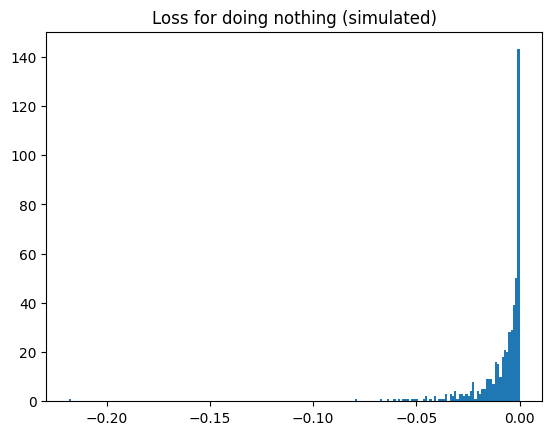

mean -0.008846207901049698
median -0.0038768214095641863


In [49]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

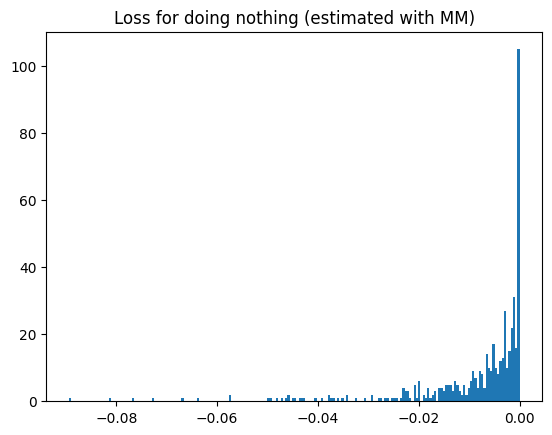

mean -0.008696803225494683
median -0.0040192600736755


In [50]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

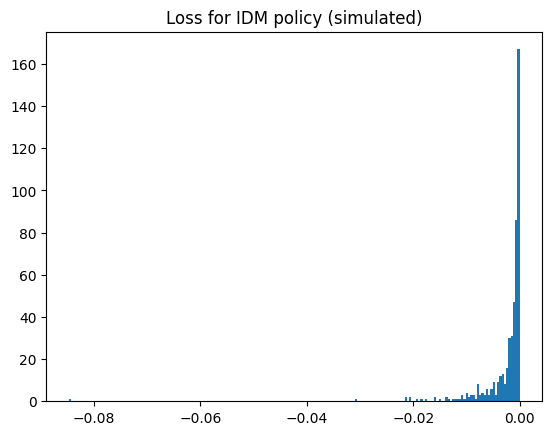

mean -0.002470740476129999
median -0.0008337771229703324


In [51]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

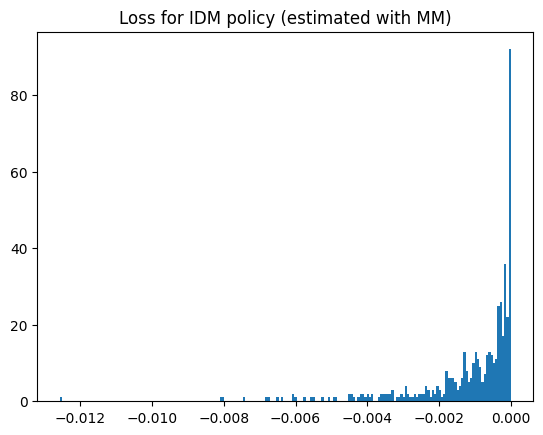

mean -0.001123346409854022
median -0.0005518965711537459


In [52]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

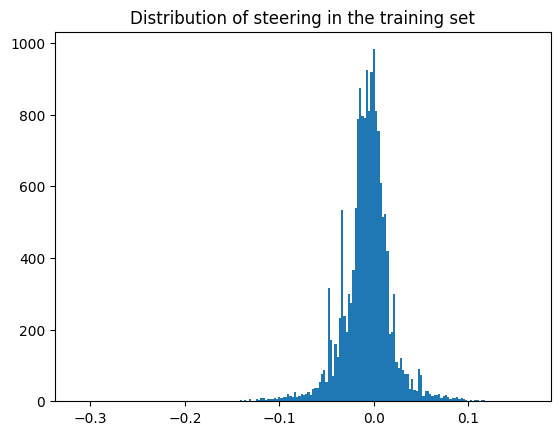

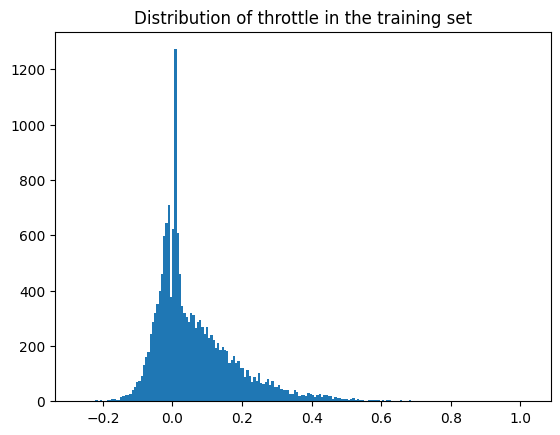

In [53]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()